In [1]:
import json

files = []
labels = []
persons = ["Ashima Gupta", "Achinth Venkat", "Oishe Farhan", "Liu Edward"]
with open('../datasets/raw/users.json') as jsonfile:
    metadata = json.load(jsonfile)
    for person in persons:
        #print(person)
        for session in metadata[person]['sessions']:
            activity = metadata[person]['sessions'][session]['activity']
            #print(activity, end=': ')
            #print(session)
            files.append(session)
            labels.append(activity)
        #print()
print(files)
print(labels)

['1552683620495_recording.csv', '1552684135826_recording.csv', '1552684518897_recording.csv', '1552684885683_recording.csv', '1552685274491_recording.csv', '1552686579599_recording.csv', '1552687068355_recording.csv', '1552687461872_recording.csv', '1552687730763_recording.csv', '1552688006554_recording.csv', '1552684886225_recording.csv', '1552685478381_recording.csv', '1552685952146_recording.csv', '1552686877018_recording.csv', '1552687454762_recording.csv', '1552687746756_recording.csv', '1552882289936_recording.csv', '1550862070278_recording.csv', '1551117337203_recording.csv', '1551117646871_recording.csv', '1551118061985_recording.csv', '1551118320943_recording.csv', '1551249571278_recording.csv', '1553039903059_recording.csv', '1553040206684_recording.csv', '1553040672641_recording.csv', '1553041018556_recording.csv', '1553041309127_recording.csv', '1553041571909_recording.csv', '1553041964221_recording.csv', '1553042270815_recording.csv', '1553042628553_recording.csv', '155268

In [2]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

def loadData(filepath, fs):
    print("Loading EEG data: "+filepath, end='...')
    try:
        with open(filepath) as file:
            pass
    except IOError:
        print("EEG data file was not found")
        exit()
    
    skip = 1
    cols = (0, 1, 2, 3, 4)
    raw_df = pd.read_csv(filepath)
    raw_df = raw_df.loc[:, ['time', 'TP9', 'AF7', 'AF8', 'TP10']]
    raw_df = raw_df.fillna(method='pad')
    raw_df = raw_df.fillna(method='bfill')
    raw_data = raw_df.values
    t_sec = np.arange(len(raw_data)) / fs
    
    print(" Complete")
    # Time, TP9, AF7, AF8, TP10
    return np.array([t_sec, raw_data[:,1], raw_data[:,2], raw_data[:,3], raw_data[:,4]])

def trimData(dataset, fs, front, back):
    """
        Trim off begin --> front
        Trim off back --> end
    """
    
    trim_front = int(front * fs)
    trim_back = int(back * fs) * -1
    if trim_back == 0:
        trim_back = dataset.shape[1]
    
    print("Trimming EEG data to be between indices {} and {}: ".format(trim_front, dataset.shape[1]+trim_back), end='...')
    dataset = dataset[:, trim_front:trim_back]
    print(" Complete")
    return dataset

def bandpass(dataset, fs, cutoffs, order=5):
    bpFs = np.array(cutoffs)
    
    filtered = []
    filtered.append(dataset[0]) # time
    
    dataiter = iter(dataset)
    next(dataiter)
    
    print("Bandpassing EEG data to be between {} Hz and {} Hz: ".format(cutoffs[0], cutoffs[1]), end='...')
    for data in dataiter:
        b, a = signal.butter(order, bpFs/(fs/2.0), 'bandpass')
        channel = signal.lfilter(b, a, data)
        filtered.append(channel)
    print(" Complete")
    return np.array(filtered)

def crunchSpecgram(dataset, fs, NFFT, overlap):
    PSD_per_hz_lst = []
    PSD_per_bin_lst = []
    freq_lst = []
    time_lst = []
    
    dataiter = iter(dataset)
    next(dataiter)
    
    print("Crunching EEG data into Spectro data: ", end='...')
    for data in dataiter:
        PSD_per_hz, freq, time = mlab.specgram(data, NFFT=NFFT, window=mlab.window_hanning, Fs=fs, noverlap=overlap)
        PSD_per_bin = PSD_per_hz * fs / float(NFFT)
        
        PSD_per_hz_lst.append(PSD_per_hz)
        PSD_per_bin_lst.append(PSD_per_bin)
        freq_lst.append(freq)
        time_lst.append(time)
    print(" Complete")
    return np.array(PSD_per_bin_lst), np.array(PSD_per_hz_lst), np.array(freq_lst), np.array(time_lst)

In [3]:
path = '../datasets/raw/'
fs = 256.0
NFFT = 512
overlap = 384

datasets = []
PSD_bins = []
PSD_hzs = []
PSD_freqs = []
PSD_times = []
for idx in range(len(files)):
    data = loadData(path+files[idx], fs)
    data = trimData(data, fs, 10, 10)
    data = bandpass(data, fs, [1, 50])
    datasets.append(data)
    PSD_bin, PSD_hz, PSD_freq, PSD_time = crunchSpecgram(data, fs, NFFT, overlap)
    PSD_bins.append(PSD_bin)
    PSD_hzs.append(PSD_hz)
    PSD_freqs.append(PSD_freq)
    PSD_times.append(PSD_time)

Loading EEG data: ../datasets/raw/1552683620495_recording.csv... Complete
Trimming EEG data to be between indices 2560 and 188876: ... Complete
Bandpassing EEG data to be between 1 Hz and 50 Hz: ... Complete
Crunching EEG data into Spectro data: ... Complete
Loading EEG data: ../datasets/raw/1552684135826_recording.csv... Complete
Trimming EEG data to be between indices 2560 and 70422: ... Complete
Bandpassing EEG data to be between 1 Hz and 50 Hz: ... Complete
Crunching EEG data into Spectro data: ... Complete
Loading EEG data: ../datasets/raw/1552684518897_recording.csv... Complete
Trimming EEG data to be between indices 2560 and 81730: ... Complete
Bandpassing EEG data to be between 1 Hz and 50 Hz: ... Complete
Crunching EEG data into Spectro data: ... Complete
Loading EEG data: ../datasets/raw/1552684885683_recording.csv... Complete
Trimming EEG data to be between indices 2560 and 81702: ... Complete
Bandpassing EEG data to be between 1 Hz and 50 Hz: ... Complete
Crunching EEG data

In [4]:
"""
    Identify Simon vs Music
"""
isSimon = np.array(labels) == 'Simon'
print(isSimon)

[ True False False False  True  True False False False False  True False
 False  True False False  True False False False False False  True  True
 False False False False False False False False  True  True False False
  True False  True]


In [5]:
print(len(datasets))
print(datasets[0][1:5,:].shape)
print(isSimon.shape)

39
(4, 186316)
(39,)


In [6]:
mean_vals_simon = []
mean_vals_music = []
for idx in range(len(PSD_hzs)):
    mean_vals = np.sum(PSD_hzs[idx], 0) # sum electrodes
    mean_vals = np.mean(mean_vals, 1) # mean of vals per hz
    if isSimon[idx]:
        mean_vals_simon.append(mean_vals)
    else:
        mean_vals_music.append(mean_vals)
mean_vals_simon = np.array(mean_vals_simon)
mean_vals_music = np.array(mean_vals_music)
print(mean_vals_simon.shape)
print(mean_vals_music.shape)
print(isSimon.shape)
mean_vals_simon = np.mean(mean_vals_simon, 0)
mean_vals_music = np.mean(mean_vals_music, 0)

# normalize
mean_vals_simon = mean_vals_simon / np.max(mean_vals_simon)
mean_vals_music = mean_vals_music / np.max(mean_vals_music)

(12, 257)
(27, 257)
(39,)


In [7]:
eeg_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 18),
    'Beta' : (18, 32),
    'Gamma': (32, 50)
}
eeg_band_fft = dict()

useIdx = 1
for band in eeg_bands:
    freq_itv = np.where((PSD_freqs[useIdx][0] >= eeg_bands[band][0]) & (PSD_freqs[useIdx][0] <= eeg_bands[band][1]))[0]
    eeg_band_fft[band+' simon vals'] = mean_vals_simon[freq_itv]
    eeg_band_fft[band+' simon freqs'] = PSD_freqs[useIdx][0][freq_itv]
    eeg_band_fft[band+' music vals'] = mean_vals_music[freq_itv]
    eeg_band_fft[band+' music freqs'] = PSD_freqs[useIdx][0][freq_itv]

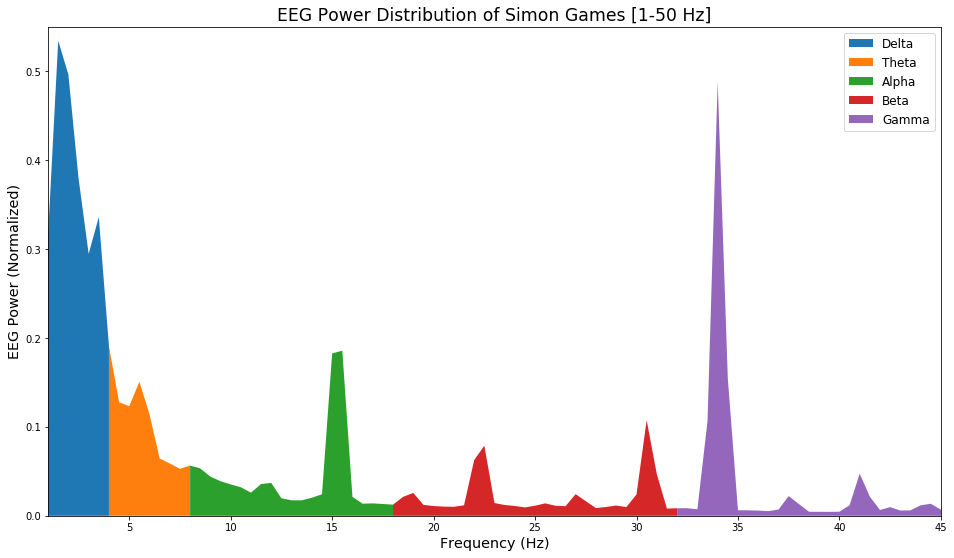

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,9))
for band in eeg_bands:
    plt.fill_between(eeg_band_fft[band+' simon freqs'], eeg_band_fft[band+' simon vals'], label=band)
plt.legend(loc='upper right', fontsize='large')
plt.title('EEG Power Distribution of Simon Games [1-50 Hz]', fontsize='xx-large')
plt.xlabel('Frequency (Hz)', fontsize='x-large')
plt.ylabel('EEG Power (Normalized)', fontsize='x-large')
plt.xlim([1,45])
plt.ylim([0,0.55])
plt.show()

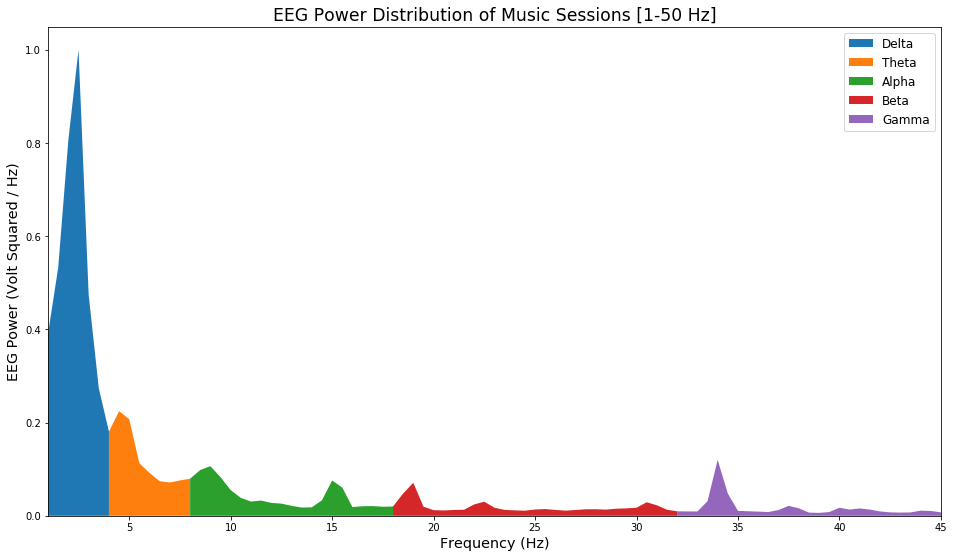

In [15]:
fig = plt.figure(figsize=(16,9))
for band in eeg_bands:
    plt.fill_between(eeg_band_fft[band+' music freqs'], eeg_band_fft[band+' music vals'], label=band)
plt.legend(loc='upper right', fontsize='large')
plt.title('EEG Power Distribution of Music Sessions [1-50 Hz]', fontsize='xx-large')
plt.xlabel('Frequency (Hz)', fontsize='x-large')
plt.ylabel('EEG Power (Volt Squared / Hz)', fontsize='x-large')
plt.xlim([1,45])
plt.ylim([0, 1.05])
plt.show()

In [ ]:
from scipy import signal

fs = 256.0
T = 1.0 / fs

fft_vals_simon = []
fft_freqs_simon = []

fft_vals_music = []
fft_freqs_music = []
for idx in range(len(datasets)):
    chSum = np.sum(datasets[idx][1:5,:], 0)
    fft_vals = np.absolute(np.fft.fft(chSum))
    fft_freqs = np.fft.fftfreq(len(chSum), T)
        
    if isSimon[idx] == True:
        fft_vals_simon.append(fft_vals)
        fft_freqs_simon.append(fft_freqs)
    else:
        fft_vals_music.append(fft_vals)
        fft_freqs_music.append(fft_freqs)
    
simonSamples = len(fft_vals_simon[0])
musicSamples = len(fft_vals_music[0])
for idx in range(1, len(fft_vals_simon)):
    if simonSamples > len(fft_vals_simon[idx]):
        simonSamples = len(fft_vals_simon[idx])
for idx in range(1, len(fft_vals_music)):
    if musicSamples > len(fft_vals_music[idx]):
        musicSamples = len(fft_vals_music[idx])

resampled_fft_vals_simon = []
resampled_fft_freqs_simon = []

resampled_fft_vals_music = []
resampled_fft_freqs_music = []

for idx in range(len(fft_vals_simon)):
    resampled_fft_vals, resampled_fft_freqs = signal.resample(fft_vals_simon[idx], simonSamples, t=fft_freqs_simon[idx])
    resampled_fft_vals_simon.append(resampled_fft_vals)
    resampled_fft_freqs_simon.append(resampled_fft_freqs)

for idx in range(len(fft_vals_music)):
    resampled_fft_vals, resampled_fft_freqs = signal.resample(fft_vals_music[idx], musicSamples, t=fft_freqs_music[idx])
    resampled_fft_vals_music.append(resampled_fft_vals)
    resampled_fft_freqs_music.append(resampled_fft_freqs)

    
resampled_fft_vals_simon = np.array(resampled_fft_vals_simon)
resampled_fft_freqs_simon = np.array(resampled_fft_freqs_simon)


resampled_fft_vals_music = np.array(resampled_fft_vals_music)
resampled_fft_freqs_music = np.array(resampled_fft_freqs_music)

In [ ]:
print(resampled_fft_vals_simon.shape)
print(resampled_fft_freqs_simon.shape)

print(resampled_fft_vals_music.shape)
print(resampled_fft_freqs_music.shape)

mean_fft_vals_simon = np.mean(resampled_fft_vals_simon, 0)
mean_fft_freq_simon = np.mean(resampled_fft_freqs_simon, 0)

mean_fft_vals_music = np.mean(resampled_fft_vals_music, 0)
mean_fft_freq_music = np.mean(resampled_fft_freqs_music, 0)

In [ ]:
plt.plot(mean_fft_freq_simon, mean_fft_vals_simon/np.max(mean_fft_vals_simon))
plt.xlim(1, 50)
plt.show()

plt.plot(mean_fft_freq_music, mean_fft_vals_music/np.max(mean_fft_vals_music))
plt.xlim(1, 50)
plt.show()